## using treesignal to plot output from guenomu on euk_ToL 
- input are species trees, not gene families (I have to fix rescaling on treesignal as I did for guenomu)
- species trees were found by MCMC on subsets of 80 genefams, where only 5% top gene trees were used
- post distrib of sptrees flat, therefore I used concatenate_trees() and MAxCredClades() from phangorn to reduce (one sptree per subset)
- also tried iGTP (DL) on subsets of 150 genefams (using MAP trees from mbayes sumt() )
- reference trees for treesignal is mixture of two guenomu ML runs using previously estimated (max cred clade) sptrees. I used 10 or so sptree estimates (each from one run) and applied two ML estimations using different distances. 

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import sys, subprocess, time, dendropy, os, copy
import numpy as np
from sklearn import manifold, metrics, cluster, neighbors, decomposition, preprocessing
import treesignal

### Loading reference trees (sptrees)

In [3]:
sptrees_file = "/home/leo/Academic/Projects/164-Katz/12.concat_mbayes_output_201703/20170409.guenomu_for_treesignal/species.trprobs"
noise_sptrees = dendropy.TreeList.get_from_path (sptrees_file, "nexus", preserve_underscores=True)
ts = treesignal.TreeSignal(sp_trees = noise_sptrees)

### Read gene trees and calculate feature matrix rows 
* Reading only first tree from each file
* function yield_from_files allow several files to be read at once, and trees being read one by one
* the calculated distances are scaled (using a single scaling factor for all distances, which is total number of branches (on both trees)

In [4]:
feat_mat = []
genesize = []
geneidx  = []
genefreq = []
genetree_dir= "/home/leo/Academic/Projects/164-Katz/12.concat_mbayes_output_201703/20170409.guenomu_for_treesignal/original/"
genefilelist = os.listdir(genetree_dir)
count=0

for fname in genefilelist:
    tyield = dendropy.Tree.yield_from_files(files=[genetree_dir + fname], schema="nexus", store_tree_weights=True, preserve_underscores=True)
    for idx, tre in enumerate (tyield): # iterate over trees as it reads (not everything in memory at once)
        if idx > 10: # read only first trees
            break
        else:
            feat_mat.append(ts(tre))
            genesize.append(len(tre.leaf_nodes()))
            genefreq.append(tre.weight)
            geneidx.append(count)
    count += 1
    
feat_mat = np.array(feat_mat)
genesize = np.array(genesize)
genefreq = np.array(genefreq)

In [5]:
signal = feat_mat/feat_mat.mean(0); 
transf=manifold.MDS(n_components=2).fit_transform(signal)

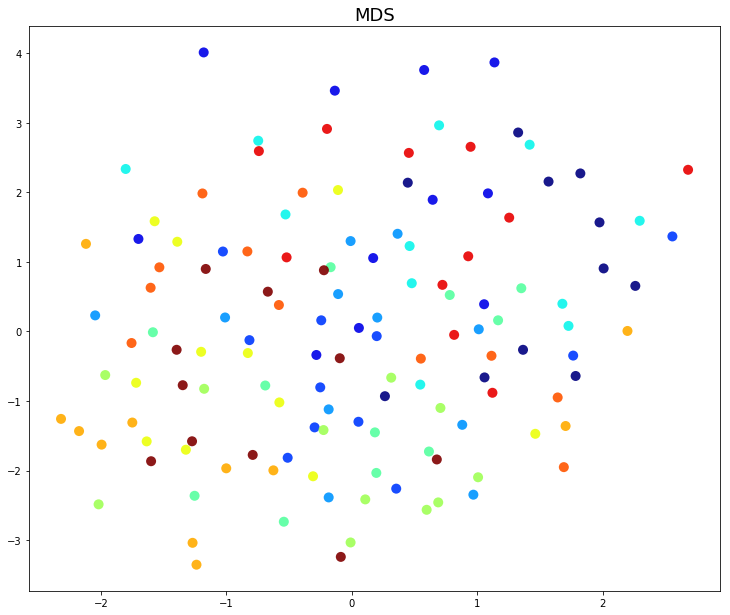

In [6]:
fig, axes = plt.subplots(1) ; fig.set_size_inches(10, 8)
fig.subplots_adjust(top=.99, bottom=.01, left=.02, right=.98, wspace=.1, hspace=.2)
jit = 0.00001 * transf.max() * np.random.normal(size=feat_mat.shape[0]) # avoid complete overlap of points
axes.scatter(transf[:,1]+jit, transf[:,0]+jit[::-1], c=geneidx, edgecolor="none", cmap="jet", alpha=.9, s=100)
axes.set_title("MDS",  fontsize=18)

In [7]:
transfeat  = decomposition.PCA(n_components=2).fit_transform(signal.T) ## order FEATURES
feat_order = np.argsort(transfeat[:,0])

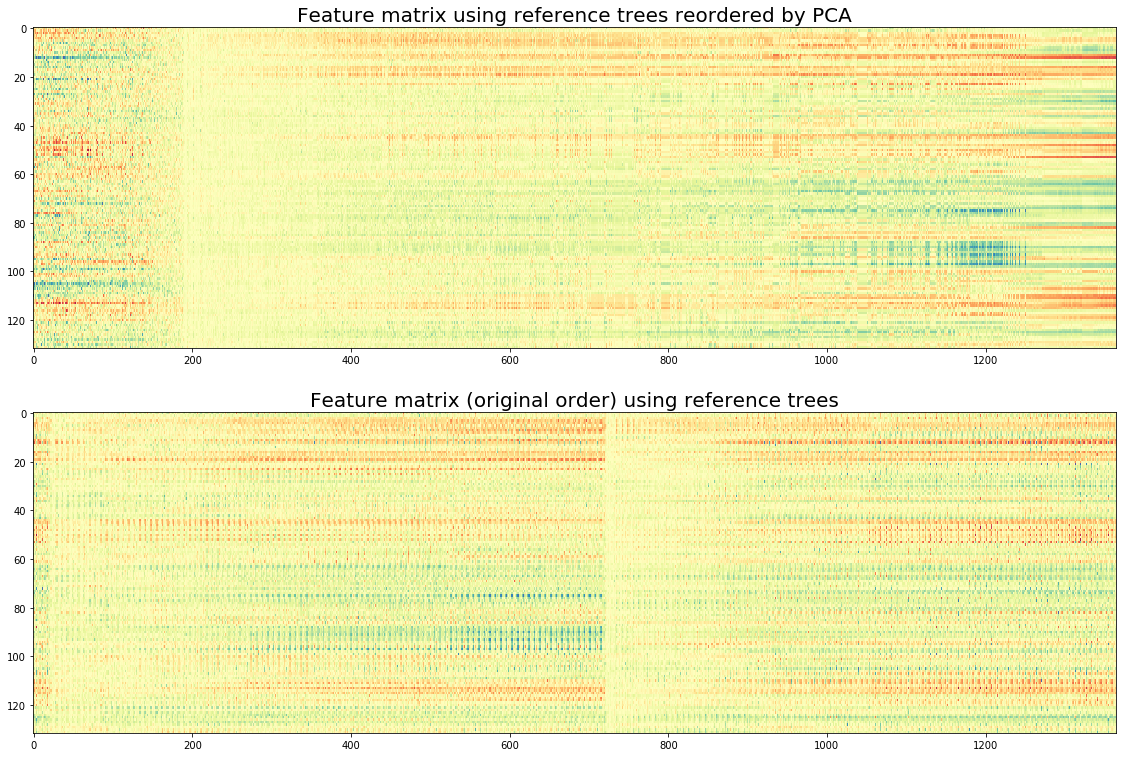

In [8]:
fig, axes = plt.subplots(2,1) ; fig.set_size_inches(16, 10)
fig.subplots_adjust(top=.99, bottom=.01, left=.03, right=.97, wspace=.1, hspace=.2)

im = axes[0].imshow(signal[:,feat_order], aspect='auto', cmap="Spectral_r", interpolation="nearest")
axes[0].set_title("Feature matrix using reference trees reordered by PCA",  fontsize=20)

im = axes[1].imshow(signal, aspect='auto', cmap="Spectral_r", interpolation="nearest")
axes[1].set_title("Feature matrix (original order) using reference trees",  fontsize=20)

Add original reference (species) trees 

In [9]:
feat_refs = ts()

In [10]:
feat_all = np.concatenate((feat_mat,feat_refs))
signal = feat_all/feat_all.mean(0); 
transf=manifold.MDS(n_components=2).fit_transform(signal)

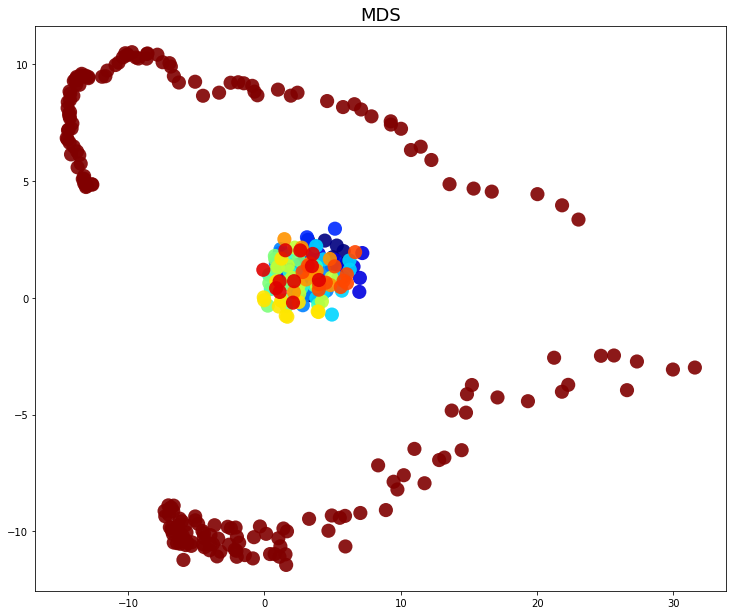

In [11]:
cols = np.concatenate((np.array(geneidx),np.repeat(max(geneidx)+1,feat_refs.shape[0])))
fig, axes = plt.subplots(1) ; fig.set_size_inches(10, 8)
fig.subplots_adjust(top=.99, bottom=.01, left=.02, right=.98, wspace=.1, hspace=.2)
axes.scatter(transf[:,1], transf[:,0],c=cols, edgecolor="none", cmap="jet", alpha=.9, s=200)
axes.set_title("MDS",  fontsize=18)